In [1]:
!export XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda-11.8/
!export CUDA_DIR="/usr/local/cuda-11.8/"
!export TF_GPU_ALLOCATOR=cuda_malloc_async

In [2]:
import tensorflow as tf
import tensorflow.keras as keras


gpus = tf.config.list_physical_devices("GPU")
print(f"gpus={gpus}")

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt

import tensorflow_datasets as tfds

2022-11-09 22:32:53.541835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 22:32:53.634031: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 22:32:54.026522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/lib64:/home/pedro/miniconda3/envs/ml2/lib/:/usr/local/cuda-11.8/lib64/lib
2022-11-09 22:32:54.026567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic li

gpus=[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
import tensorflow_addons as tfa
import datetime
import random

In [4]:
mnist = tf.keras.datasets.fashion_mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

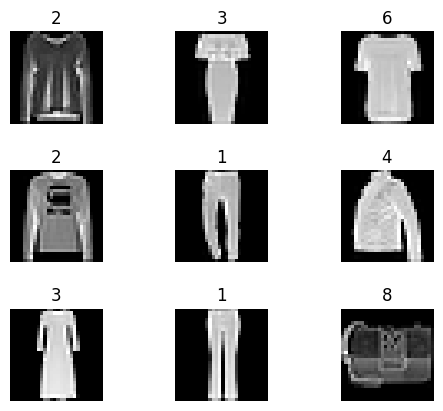

In [5]:
def print_validation(fn):
    random.seed(10)
    rows = 3
    cols = 3
    indices = np.random.randint(0, 10000, 9)
    rand = x_test[indices].reshape((cols, rows, 1, 28, 28, 1))
    rand_y = y_test[indices].reshape((cols, rows, 1))

    fig, axs = plt.subplots(rows, cols)
    for i in range(rows):
        for j in range(cols):
            predicted = fn(rand[i,j])
            axs[i,j].set_title(rand_y[i,j][0])
            axs[i,j].imshow(predicted, cmap = "gray")
            axs[i, j].axis("off")

    plt.subplots_adjust(wspace = 0, hspace = 0.5)
    plt.show()

print_validation(lambda x: x[0])

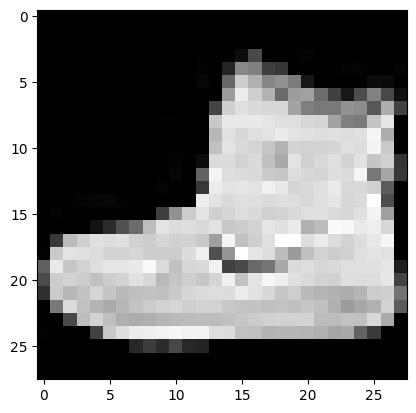

In [6]:
# Plot image data from x_train
plt.imshow(x_train[0], cmap = "gray")
plt.show()

In [7]:
LATENT_SIZE = 32

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam()

def get_conv(filters):
    conv = tf.keras.Sequential()
    conv.add(tfa.layers.SpectralNormalization(
        layers.Conv2D(filters, 3, padding="same", use_bias=False)
    ))
    conv.add(layers.LeakyReLU())
    return conv
    
def get_encoder(filters=[16,64,128]):
    print(f"encfilter:{filters}")
    encoder = tf.keras.Sequential(name="encoder")
    # encoder.add(layers.GaussianDropout(0.2))
    encoder.add(get_conv(filters[0]))
    encoder.add(layers.MaxPooling2D(pool_size = (2, 2), padding='same'))
    encoder.add(get_conv(filters[1]))
    encoder.add(layers.MaxPooling2D(pool_size = (2, 2), padding='same'))
    encoder.add(get_conv(filters[2]))
    return encoder

def get_decoder(filters=[64,16]):
    print(f"decfilter:{filters}")
    decoder = tf.keras.Sequential(name="decoder")
    
    decoder.add(layers.Conv2DTranspose(filters[0], 3, strides=2, padding="same", use_bias=False))
    decoder.add(layers.Conv2DTranspose(filters[1], 3, strides=2, padding="same", use_bias=False))
#     decoder.add(layers.UpSampling2D((2, 2), interpolation='bilinear'))
#     decoder.add(get_conv(filters[0]))
#     decoder.add(layers.UpSampling2D((2, 2), interpolation='bilinear'))
#     decoder.add(get_conv(filters[1]))
    decoder.add(layers.Conv2D(1, 3, padding='same', activation='tanh'))
    return decoder

class AutoEncoder(tf.keras.Model):
  def __init__(self, encoder_conf, decoder_conf):
    super(AutoEncoder, self).__init__()
    self.encoder_conf = encoder_conf
    self.decoder_conf = decoder_conf
    
  def build(self, input_shape):
    self.encoder = get_encoder(self.encoder_conf)
    self.decoder = get_decoder(self.decoder_conf)
    
    self.encoder.build(input_shape=input_shape)
    
    sh = self.encoder.output_shape
    
    self.flatten = layers.Flatten()
    self.seq1 = layers.Dense(1024)
    print(sh)
    self.reshape = layers.Reshape([*sh[1:]])
    
    self.last = layers.Conv2D(1, 3, padding='same', activation='tanh')
    self.inputs_dropout = layers.Dropout(0.2)

    
  def call(self, inputs):
    x = self.inputs_dropout(inputs)
    x = self.encoder(x)
    x = self.flatten(x)
    x = self.reshape(x)
    x = self.decoder(x)
    
    # x_inputs = self.conv_input(inputs)
    
    # x = self.add([x * self.gamma, x_inputs])
    # x = self.attention(x)
    x = self.last(x)
    return x

In [9]:
y = tf.expand_dims(x_train[0], axis=0)
y = tf.expand_dims(y, axis=3)

print(y.shape)

enc = get_encoder([16,64,128])(y)
print(enc.shape)

dec = get_decoder([64,14])(enc)

print(dec.shape)

2022-11-09 22:32:55.540239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 22:32:55.639827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 22:32:55.640047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 22:32:55.640227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

(1, 28, 28, 1)
encfilter:[16, 64, 128]


2022-11-09 22:32:56.886397: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


(1, 7, 7, 128)
decfilter:[64, 14]
(1, 28, 28, 1)


In [10]:
generated_images = []

def train_get():
   for x, y in zip(x_train, y_train):
        x = tf.expand_dims(x, axis=2)
        generated_images.append(y)
        yield x

def test_get():
   for x in x_test:
        x = tf.expand_dims(x, axis=2)
        yield x

output_signature=tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32)

BATCH_SIZE = 25

def get_train_ds():
    return tf.data.Dataset.from_generator(train_get, output_signature=output_signature).map(lambda x: (x,x)).batch(BATCH_SIZE)

def get_test_ds():
    return tf.data.Dataset.from_generator(test_get, output_signature=output_signature).map(lambda x: (x,x)).take(100).batch(BATCH_SIZE)

In [11]:
# %tensorboard --logdir logs/minst/

In [12]:
configs = [
    ([8,16,32], [16,8]),
    ([16,64,128], [64,16]),
    ([32,64,128], [64,32]),
    ([32,64,256], [64,32]),
]

def conf_name(conf):
    enc, dec = conf
    print(enc)
    return "k".join(map(lambda x:str(x), enc)) + "-" + "k".join(map(lambda x:str(x), dec))
str(conf_name(configs[0]))

[8, 16, 32]


'8k16k32-16k8'

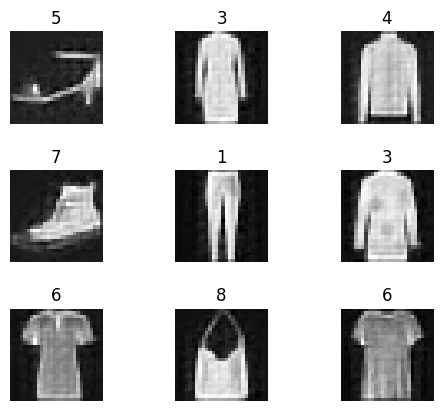

Validation Loss: 0.26406362652778625
500/500 [==============================] - 3s 7ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0066 - val_mse: 0.0066


In [13]:
# class MyModel(tf.keras.Model):
#   def __init__(self, autoencoder):
#     super(MyModel, self).__init__()
#     self.autoencoder = autoencoder

#   def call(self, inputs, training=False):
#     return self.autoencoder(inputs, training=training)

  # def validation_step(self, images):
  #   pass

  # def train_step(self, images):
  #   with tf.GradientTape() as auto_tape:
  #     generated = self.autoencoder(images)
  #     loss = cross_entropy(images, generated)
  #   gradients = auto_tape.gradient(loss, self.autoencoder.trainable_variables)
  #   opt.apply_gradients(zip(gradients, self.autoencoder.trainable_variables))

  #   return {"loss": loss}
    


for conf in configs:    
    train_log_dir = f'logs/minst/conv2dt_{conf_name(conf)}'
    enc_conf, dec_conf = conf
    
    tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = train_log_dir,
      write_graph=True,
      histogram_freq = 1,
      update_freq="batch"
      )

    EPOCHS = 60
    # autoencoder = AutoEncoder()
    model = AutoEncoder(enc_conf, dec_conf)


    class SkMetrics(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.validation_loss = []   

        def on_batch_end(self, batch, logs={}):
          originals = []
          predicted = []
          def expand_and_predict(x):
            result = model(x, training=False)
            originals.append(x)
            predicted.append(result)
            return result[0]
          if batch % 299 == 0 and batch > 0:
            display.clear_output()
            print_validation(expand_and_predict)

            loss = cross_entropy(originals, predicted)
            tf.summary.scalar('validation_loss', loss)
            print(f"Validation Loss: {loss}")

    class CustomMSE(keras.losses.Loss):
        def __init__(self, name="custom_mse"):
            super().__init__(name=name)

        def call(self, y_true, y_pred):
            mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
            return mse


    # model.compile(run_eagerly=True)
    model.compile(loss=keras.losses.MeanSquaredError(), optimizer=opt, metrics=["mse"])
    history = model.fit(get_train_ds().repeat(), epochs=100, steps_per_epoch=500, validation_data=get_test_ds(), callbacks=[SkMetrics(), tboard_callback])


In [14]:
len(generated_images), 5*5*2

(5000200, 50)